In [73]:
import numpy as np
from matplotlib import pyplot as plt

In [74]:
# reference distance (meters)
d0 = 1 
# constant for particular propagation enviroment
k = 1e-4
# path loss exponent
n = 4
# total available bandwidth (Hz)
b_t = 100 * 1e6
# constant for noise power (W/Hz)
k_0 = 1e-20
# Side of total area (meters)
area_side = 1000

In [75]:
def lin2db(x):
    return 10.0*np.log10(x)

def db2lin(x):
    return 10.0**(x/10.0)

def lin2dbm(x):
    return 10.0*np.log10(x)+30.0

def dbm2lin(x):
    return 10.0**(x/10.0 - 3.0)

#####################################################################################################

def distance(AP_position):
    x_position = np.random.rand()*1e3
    y_position = np.random.rand()*1e3
    return np.linalg.norm(np.array([x_position, y_position])
                          - np.array(AP_position))

def received_power(transmitted_power, distance):
    return transmitted_power * (k / (distance**n))
    
def bandwidth_channel(total_bandwidth, channels_quantity):
    return total_bandwidth / channels_quantity

def noise_power(total_bandwidth, channels_quantity):
    return k_0 * bandwidth_channel(total_bandwidth, channels_quantity)

def calculate_SNR(user_power, noise_power):
    return user_power / noise_power

def calculate_SINR(user_power, interference_power, noise_power):
    return user_power / (interference_power + noise_power)

##################################################################################################

def eCDF(data):
    x = np.sort(data)
    y = np.arange(0, len(data)) / len(data)

    return x, y  

In [76]:
# Models the UEs
class UserEquipment:
    
    def __init__(self, power_ = 1): # UE transmission power is 1 W by standard
        
        # Distance is sorted randomly in a 1000x1000m area 
        self.distance2AP = distance([500, 500])
        
        self.power = power_

In [77]:
class AccessPoint:

    def __init__(self, position_ = [0, 0]):

        self.position = position_

In [ ]:
class Plots:
    
    def __init__(self, AP_quantity):

        self.quantity = AP_quantity
        
        self.AP_list = []
        
        if np.sqrt(AP_quantity).is_integer():
            
            y_ = area_side / (2 * np.sqrt(AP_quantity)) 
                
            for i in range(int(np.sqrt(AP_quantity))):

                x_ = area_side / (2 * np.sqrt(AP_quantity)) 
                addition = 2 * x_
                
                for i in range(int(np.sqrt(AP_quantity))):
                    self.AP_list.append(AccessPoint([x_, y_]))
                    x_ += addition

                y_ += addition

            

In [78]:
# Creates and stores the UES
class UserPlot:
    
    def __init__(self, quantity_):
        
        self.quantity = quantity_
        
        # list of powers receiveds by AP (watts)
        self.users_received_power = np.zeros(quantity_)
        
        for i in range(quantity_):
            temp_user = UserEquipment()
            if temp_user.distance2AP >= d0:
                self.users_received_power[i] = received_power(temp_user.power, 
                                                              temp_user.distance2AP)

In [79]:
# Admiting only 1 channel, the noise power
noise_p = noise_power(b_t, 1)

# Models a System to manage the link between UE and AP
class LinkSystem:
    
    def __init__(self, users_):
        
        if isinstance(users_, UserPlot):
            
            self.SNR_list = np.zeros(len(users_.users_received_power))
            self.SINR_list = np.zeros(len(users_.users_received_power))
            self.capacity_list = np.zeros(len(self.SINR_list))
            
            # Calculating SNR
            for user_power in range(len(users_.users_received_power)):
                self.SNR_list[user_power] = lin2db(calculate_SNR(users_.users_received_power[user_power], 
                                                                 noise_p))
                
            # Calculating SINR
            for user_power_ in range(len(users_.users_received_power)):
                auxiliar_received_power = list(users_.users_received_power)
                UE_used = users_.users_received_power[user_power_]
                auxiliar_received_power.pop(user_power_)
                interfering_sum = sum(auxiliar_received_power)
                
                self.SINR_list[user_power_] = lin2db(UE_used / (interfering_sum + noise_p))
                
                # self.SINR_list[user_] = lin2db(calculate_SINR(UE_used, interfering_sum, noise_p))
    
            # Calculating Capacity
            for user_SINR_ in range(len(self.SINR_list)):
                bandwidth_ = bandwidth_channel(b_t, 10)
                self.capacity_list[user_SINR_] = (bandwidth_ 
                                                  * (np.log2(1 
                                                  + db2lin(self.SINR_list[user_SINR_]))) 
                                                  / 1e6)
                

In [80]:
# Simulation parameters

iteracoes = 1000 # The quantity of simulations
users_quantity = 100

In [81]:
total_SNR = []
total_SINR = []
total_capacity = []

for inter in range(iteracoes):
    # Creates many Users at once
    users = UserPlot(users_quantity)
    
    # The SNR and SINR of users
    system = LinkSystem(users)
    
    total_SNR = np.concatenate((total_SNR, system.SNR_list))
    
    total_SINR = np.concatenate((total_SINR, system.SINR_list))
    
    total_capacity = np.concatenate((total_capacity, system.capacity_list))


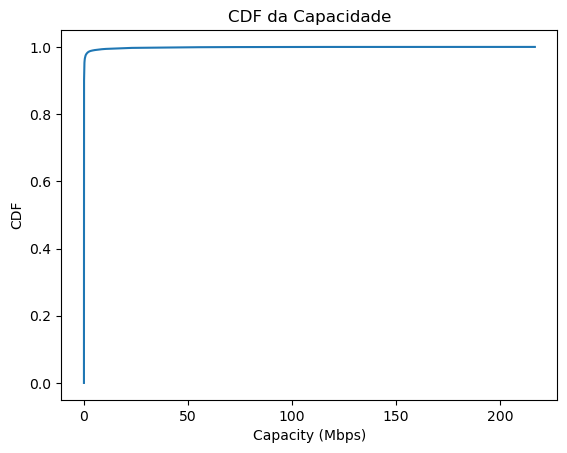

In [82]:
capacityCDF = eCDF(total_capacity)

plt.title('CDF da Capacidade')
plt.xlabel('Capacity (Mbps)')
plt.ylabel('CDF')

plt.plot(capacityCDF[0], capacityCDF[1])
plt.show()